In [1]:
from collections import defaultdict
import json
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import auc
import sys
    
def interpolate(x, y, x_t):
    y_rev = list(reversed(list(y)))
    x_rev = list(reversed(list(x)))
    return np.interp(x_t, x_rev, y_rev)

def average_same_x(x, y_list):
    n = len(x)
    d = len(y_list)
    out = []
    for i in range(n):
        v = 0.0
        for j in range(d):
            v += y_list[j][i]
        v /= d
        out.append(v)
    return out

In [2]:
modes = {'initial-tune': 'Baseline', 'combined-transfer-ptune': 'SPIRE', 'fs-tune-ptune': 'FS'}
trials = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
baseline = 'initial-tune'
corrected_list = ['combined-transfer-ptune', 'fs-tune-ptune']

label1='runway'
label2='street'
spurious='airplane'
main_dir = './2-Models/Models/{}-{}/{}'.format(label1, label2, spurious)

orig_splits = ['1s', '0ns'] # Which splits have enough data to estimate accuracy in the original dataset
orig_cfs = []
for split in orig_splits:
    if 'ns' in split:
        orig_cfs.append('{}+spurious'.format(split))
    else:
        orig_cfs.append('{}-spurious/box'.format(split))
        orig_cfs.append('{}-spurious/pixel-paint'.format(split))
        
index_target = 70 # Threshold of 0.5 for the original model gives recall of 70%


# Verify that accuracy on the External data is consistent with the Original data

In [3]:
for mode in modes:
    print(modes[mode])
    print()
    for split in orig_splits:
        v_orig = []
        v_ext = []
        for trial in trials:
            with open('{}/{}/trial{}/results.pkl'.format(main_dir, mode, trial), 'rb') as f:
                results = pickle.load(f)
            v_orig.append(results['orig-{}'.format(split)])
            v_ext.append(results[split][51]) #threshold = 0.5

        print(split)
        print('Orig: {} ({})'.format(np.round(np.mean(v_orig), 3), np.round(np.std(v_orig), 3)))
        print('Ext: {} ({})'.format(np.round(np.mean(v_ext), 3), np.round(np.std(v_ext), 3)))
        print()    
    print()


Baseline

1s
Orig: 0.956 (0.036)
Ext: 0.906 (0.063)

0ns
Orig: 0.998 (0.002)
Ext: 1.0 (0.0)


SPIRE

1s
Orig: 0.805 (0.045)
Ext: 0.723 (0.048)

0ns
Orig: 0.998 (0.002)
Ext: 1.0 (0.0)


FS

1s
Orig: 0.926 (0.047)
Ext: 0.871 (0.056)

0ns
Orig: 0.998 (0.001)
Ext: 1.0 (0.0)




# 'Metric-Recall' Analysis


Baseline
1s 0.8927
1ns 0.5073
0s 0.7417
0ns 1.0
r-gap 0.3854
h-gap 0.2583
ap 0.2789


SPIRE
1s 0.6771
1ns 0.7229
0s 0.9667
0ns 1.0
r-gap 0.0708
h-gap 0.0333
ap 0.7815


FS
1s 0.8729
1ns 0.5271
0s 0.7542
0ns 1.0
r-gap 0.3458
h-gap 0.2458
ap 0.2969



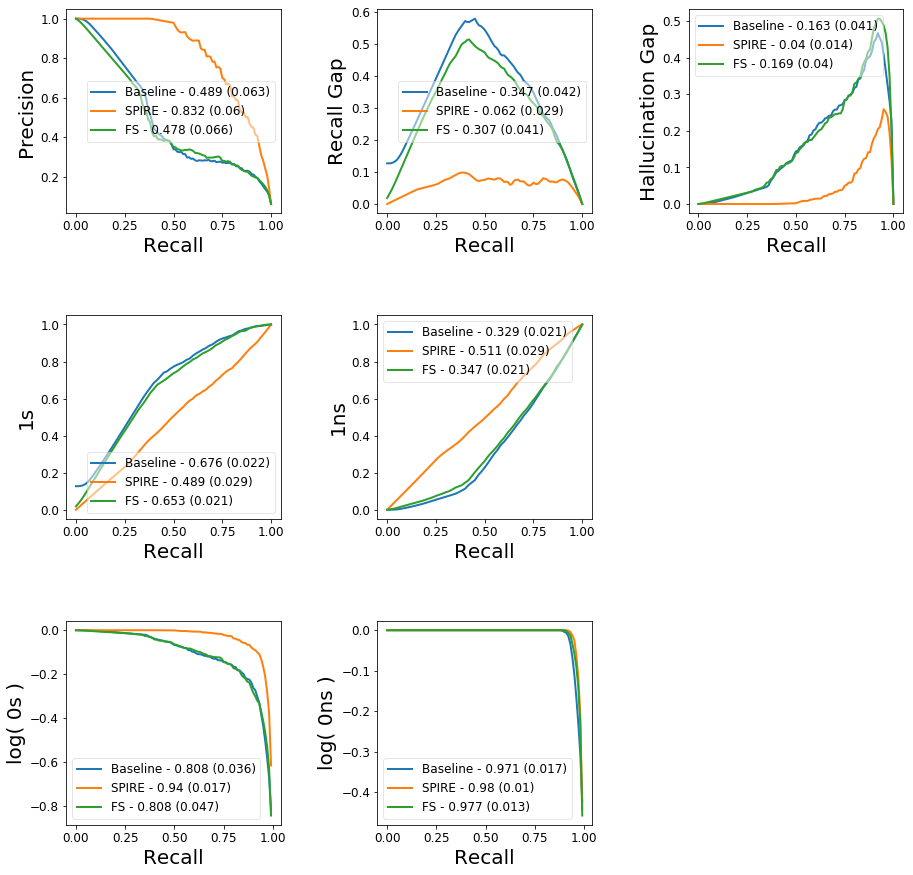

In [4]:
show_accs = True
np.seterr(divide = 'ignore') 

mpl.rcParams['font.size'] = 20
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['legend.framealpha'] = 0.5
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

ts = np.linspace(0, 1, num = 101)

if show_accs:
    fig, ax_all = plt.subplots(3, 3)
    fig.set_figheight(15)
    fig.set_figwidth(15)        
else:
    fig, ax_all = plt.subplots(1, 3)
    fig.set_figheight(5)
    fig.set_figwidth(15)
fig.subplots_adjust(hspace = 0.5, wspace = 0.45)

pr = {}

for mode in modes:

    values = {'ap': [], 'r-gap': [], 'h-gap': [], '1s': [], '1ns': [], '0s': [], '0ns': []} 
    curves = {'ap': [], 'r-gap': [], 'h-gap': [], '1s': [], '1ns': [], '0s': [], '0ns': []} 
    for trial in trials:
    
        with open('{}/{}/trial{}/results.pkl'.format(main_dir, mode, trial), 'rb') as f:
            results = pickle.load(f)
        
        curve_tmp = interpolate(results['recall'], results['precision'], ts)
        curves['ap'].append(curve_tmp)
        values['ap'].append(auc(ts, curve_tmp))
        
        for name in curves:
            if name != 'ap':
                curve_tmp = interpolate(results['recall'], results[name], ts)
                curves[name].append(curve_tmp)
                values[name].append(auc(ts, curve_tmp))               

    values_avg = {}
    values_std = {}
    curves_avg = {}
    for name in values:
        values_avg[name] = np.round(np.mean(values[name]), 3)
        values_std[name] = np.round(np.std(values[name]), 3)
        curves_avg[name] = average_same_x(ts, curves[name])
        
    print()
    print(modes[mode])
    for name in ['1s', '1ns', '0s', '0ns', 'r-gap', 'h-gap', 'ap']:
        print(name, np.round(curves_avg[name][index_target], 4))
    print()

    pr[mode] = curves_avg['ap']
    
    if show_accs:
        ax = ax_all[0,0]
    else:
        ax = ax_all[0]
    ax.plot(ts, curves_avg['ap'], label = '{} - {} ({})'.format(modes[mode], values_avg['ap'], values_std['ap']))
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.legend()

    if show_accs:
        ax = ax_all[0,1]
    else:
        ax = ax_all[1]
    ax.plot(ts, curves_avg['r-gap'], label = '{} - {} ({})'.format(modes[mode], values_avg['r-gap'], values_std['r-gap']))
    ax.set_xlabel('Recall')
    ax.set_ylabel('Recall Gap')
    ax.legend()

    if show_accs:
        ax = ax_all[0,2]
    else:
        ax = ax_all[2]
    ax.plot(ts, curves_avg['h-gap'], label = '{} - {} ({})'.format(modes[mode], values_avg['h-gap'], values_std['h-gap']))
    ax.set_xlabel('Recall')
    ax.set_ylabel('Hallucination Gap')
    ax.legend()

    if show_accs:
        ax = ax_all[1,0]
        ax.plot(ts, curves_avg['1s'], label = '{} - {} ({})'.format(modes[mode], values_avg['1s'], values_std['1s']))
        ax.set_xlabel('Recall')
        ax.set_ylabel('1s')
        ax.legend()

        ax = ax_all[1,1]
        ax.plot(ts, curves_avg['1ns'], label = '{} - {} ({})'.format(modes[mode], values_avg['1ns'], values_std['1ns']))
        ax.set_xlabel('Recall')
        ax.set_ylabel('1ns')
        ax.legend()

        ax = ax_all[2,0]
        ax.plot(ts, np.log10(curves_avg['0s']), label = '{} - {} ({})'.format(modes[mode], values_avg['0s'], values_std['0s']))
        ax.set_xlabel('Recall')
        ax.set_ylabel('log( 0s )')
        ax.legend()

        ax = ax_all[2,1]
        ax.plot(ts, np.log10(curves_avg['0ns']), label = '{} - {} ({})'.format(modes[mode], values_avg['0ns'], values_std['0ns']))
        ax.set_xlabel('Recall')
        ax.set_ylabel('log( 0ns )')
        ax.legend()

        ax_all[1,2].set_axis_off()
        ax_all[2,2].set_axis_off()

plt.show()
plt.close()

np.seterr(divide = 'warn');


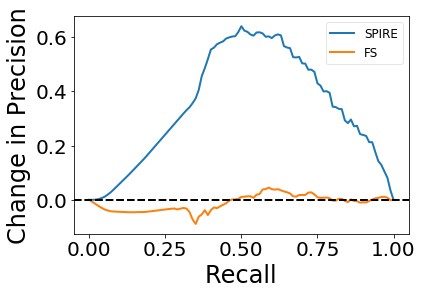

In [5]:
mpl.rcParams['font.size'] = 24
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20

for corrected in corrected_list:    
    y_agg_b = np.array(pr[baseline])
    y_agg_c = np.array(pr[corrected])
    plt.plot(ts, y_agg_c - y_agg_b, label = modes[corrected])
    plt.axhline(y=0, linestyle='dashed', c = 'black')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Change in Precision')
    
plt.show()
plt.close()

# Counterfactual Evaluation

In [6]:
for mode in modes:
    print(modes[mode])
    print()
    for metric in orig_cfs:
        v = []
        for trial in trials:
            with open('{}/{}/trial{}/counterfactual.json'.format(main_dir, mode, trial), 'r') as f:
                results = json.load(f)
            v.append(results[metric])

        print('{}: {} ({})'.format(metric, np.round(np.mean(v), 3), np.round(np.std(v), 3)))
    print()
    print()

Baseline

1s-spurious/box: 0.526 (0.137)
1s-spurious/pixel-paint: 0.426 (0.083)
0ns+spurious: 0.079 (0.017)


SPIRE

1s-spurious/box: 0.14 (0.059)
1s-spurious/pixel-paint: 0.222 (0.078)
0ns+spurious: 0.004 (0.003)


FS

1s-spurious/box: 0.517 (0.129)
1s-spurious/pixel-paint: 0.414 (0.063)
0ns+spurious: 0.064 (0.022)


